In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [3]:
cad_df = pd.read_csv('final_data.csv')
cad_df['Cath'].value_counts()

Cath
0    216
1     87
Name: count, dtype: int64

# ***Backward Elimination***

In [4]:
#Separate features and target columns
X_feature = cad_df.drop('Cath', axis=1)
y_target = cad_df['Cath']

rf_model = RandomForestClassifier(random_state=1)
forward_selector = SequentialFeatureSelector(estimator=rf_model, k_features=30, forward=False, floating=False, scoring='accuracy', cv=2)
select_fit = forward_selector.fit(X_feature, y_target)
selected_features = X_feature.columns[list(select_fit.k_feature_idx_)]
X_backward = X_feature[selected_features]

print('Selected features with Backward Elimination: ', selected_features)
print("\nDataframe with only the selected features:")
print(X_backward.head(5))

Selected features with Backward Elimination:  Index(['Age', 'Sex', 'BMI', 'HTN', 'Current Smoker', 'EX-Smoker', 'FH',
       'Obesity', 'CRF', 'CVA', 'Thyroid Disease', 'Weak Peripheral Pulse',
       'Lung rales', 'Diastolic Murmur', 'Typical Chest Pain',
       'Function Class', 'LowTH Ang', 'Q Wave', 'St Elevation',
       'St Depression', 'Tinversion', 'LVH', 'Poor R Progression', 'FBS', 'CR',
       'ESR', 'HB', 'K', 'EF-TTE', 'Region RWMA'],
      dtype='object')

Dataframe with only the selected features:
   Age  Sex        BMI  HTN  Current Smoker  EX-Smoker  FH  Obesity  CRF  CVA  \
0   53    1  29.387755    1               1          0   0        1    0    0   
1   67    0  28.398718    1               0          0   0        1    0    0   
2   54    1  20.077335    0               1          0   0        0    0    0   
3   66    0  26.838648    1               0          0   0        1    0    0   
4   50    0  37.165193    1               0          0   0        1    0    0

# ***Data splitting***

In [5]:
#60% data for training, 20% data for validation, 20% data for testing
X_train, X_temp, y_train, y_temp = train_test_split(X_backward, y_target, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

print(f"The training set contains {X_train.shape[0]} patient records and {X_train.shape[1]} features.")
print(f"The validation set contains {X_val.shape[0]} patient records with the same {X_val.shape[1]} features.")
print(f"The test set also holds {X_test.shape[0]} patient records, each with {X_test.shape[1]} features.")

The training set contains 181 patient records and 30 features.
The validation set contains 61 patient records with the same 30 features.
The test set also holds 61 patient records, each with 30 features.


# ***SMOTENC***

In [6]:
categorical_cols = [col for col in X_train.columns if X_train[col].nunique() <= 4]
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=1)
X_balanced, y_balanced = smote_nc.fit_resample(X_train, y_train)

print("Imbalanced distribution:", Counter(y_train))
print("Balanced distribution:", Counter(y_balanced))

Imbalanced distribution: Counter({0: 133, 1: 48})
Balanced distribution: Counter({1: 133, 0: 133})


Applied SMOTENC balancing only to the testing set

In [7]:
X_balanced

Age  Sex        BMI  HTN  Current Smoker  EX-Smoker  FH  Obesity  CRF  \
0     53    1  34.086605    0               1          0   0        1    0   
1     53    1  27.681661    1               1          0   0        1    0   
2     80    0  23.283419    1               0          0   0        0    0   
3     55    1  28.401111    0               0          0   1        1    0   
4     68    0  26.666667    1               0          0   0        1    0   
..   ...  ...        ...  ...             ...        ...  ..      ...  ...   
261   55    1  32.390436    0               0          0   0        1    0   
262   46    1  27.653971    0               0          0   0        0    0   
263   52    0  28.106269    0               0          0   0        1    0   
264   40    0  26.209190    0               0          0   0        1    0   
265   54    1  29.278518    0               0          0   0        1    0   

     CVA  ...  Tinversion  LVH  Poor R Progression  FBS        CR  ESR  \
0      0  ...           0    0                   0  108  1.200000    6   
1      0  ...           1    0                   0  123  0.900000   36   
2      0  ...           0    0                   0   94  1.000000   12   
3      0  ...           1    0                   0   94  1.300000    6   
4      0  ...           0    0                   1  360  1.300000   55   
..   ...  ...         ...  ...                 ...  ...       ...  ...   
261    0  ...           0    0                   0  115  1.210564    9   
262    0  ...           0    0                   0  102  1.152609    4   
263    0  ...           0    0                   0   91  0.887583   15   
264    0  ...           0    0                   0   80  0.683755   23   
265    0  ...           0    0                   0   85  1.041424    7   

            HB         K  EF-TTE  Region RWMA  
0    14.600000  4.200000      55            0  
1    14.500000  3.700000      40            1  
2    12.300000  5.100000      40            4  
3    15.300000  3.800000      45            0  
4    11.000000  3.900000      55            0  
..         ...       ...     ...          ...  
261  14.091896  3.223589      52            0  
262  14.905219  4.068406      36            0  
263  13.474504  3.987583      55            0  
264  11.005061  3.811673      55            0  
265  13.501298  3.717152      52            0  

[266 rows x 30 columns]

# ***Random Forest Classifier (RF)***

In [8]:
param_random = {'n_estimators': [50, 100, 150],
                'max_depth': [2, 3, 4],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [2, 4, 8],
                'max_features': ['sqrt', 'log2']}

RF_mdl = RandomForestClassifier()
RF_randomcv = RandomizedSearchCV(RF_mdl, param_random, n_iter=20, cv=5)
RF_randomcv.fit(X_balanced, y_balanced)
RF_param = RF_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(RF_randomcv.best_score_))
print("Optimal parameters of RF classifier: ", RF_param)

#Training RF model with optimal parameters
RF_best_mdl = RandomForestClassifier(**RF_param)
RF_best_mdl.fit(X_balanced, y_balanced)
training_acc = RF_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of RF classifier: {training_acc:.4f}")

Best cross-validation score: 0.94
Optimal parameters of RF classifier:  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 3}
Training phase accuracy of RF classifier: 0.9436


*Predicting on the validation and testing data*

In [9]:
val_pred = RF_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = RF_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        42
           1       0.72      0.68      0.70        19

    accuracy                           0.82        61
   macro avg       0.79      0.78      0.79        61
weighted avg       0.82      0.82      0.82        61

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        41
           1       0.86      0.95      0.90        20

    accuracy                           0.93        61
   macro avg       0.92      0.94      0.93        61
weighted avg       0.94      0.93      0.94        61



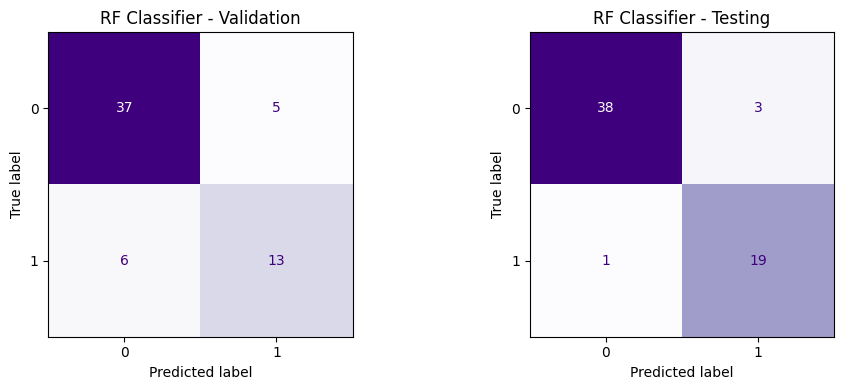

In [10]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the validation confusion matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('RF Classifier - Validation')

# Plotting the testing confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('RF Classifier - Testing')

plt.tight_layout()
plt.show()

# ***XGBoost (XGB)***

In [11]:
param_random = {'n_estimators': [50, 80, 100],
                'max_depth': [2, 3, 4],
                'learning_rate': [0.01, 0.02, 0.05],
                'subsample': [0.6, 0.7, 0.8]}

XGB_mdl = XGBClassifier()
XGB_randomcv = RandomizedSearchCV(XGB_mdl, param_random, n_iter=20, cv=5)
XGB_randomcv.fit(X_balanced, y_balanced)
XGB_param = XGB_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(XGB_randomcv.best_score_))
print("Optimal parameters of XGB classifier: ", XGB_param)

#Training XGB model with optimal parameters
XGB_best_mdl = XGBClassifier(**XGB_param)
XGB_best_mdl.fit(X_balanced, y_balanced)
training_acc = XGB_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of XGB classifier: {training_acc:.4f}")

Best cross-validation score: 0.92
Optimal parameters of XGB classifier:  {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}
Training phase accuracy of XGB classifier: 0.9812


*Predicting on the validation and testing data*

In [12]:
val_pred = XGB_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = XGB_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        42
           1       0.76      0.68      0.72        19

    accuracy                           0.84        61
   macro avg       0.81      0.79      0.80        61
weighted avg       0.83      0.84      0.83        61

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        41
           1       0.81      0.85      0.83        20

    accuracy                           0.89        61
   macro avg       0.87      0.88      0.87        61
weighted avg       0.89      0.89      0.89        61



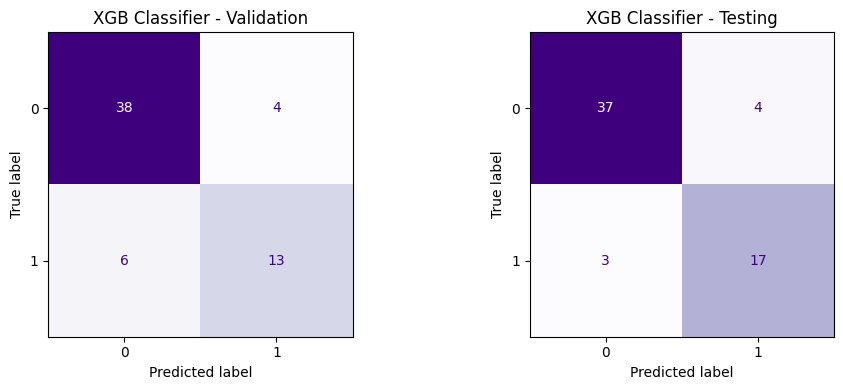

In [13]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('XGB Classifier - Validation')

disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('XGB Classifier - Testing')

plt.tight_layout()
plt.show()

# ***Gradient Boosting (GB)***

In [14]:
param_random = {'n_estimators': [50, 100, 150],
                'max_depth': [2, 3, 4],
                'learning_rate': [0.005, 0.001, 0.015],
                'subsample': [0.6, 0.7, 0.8],
                'min_samples_split': [10, 12],
                'min_samples_leaf': [6, 8, 10]}

GB_mdl = GradientBoostingClassifier()
GB_randomcv = RandomizedSearchCV(GB_mdl, param_random, n_iter=20, cv=5)
GB_randomcv.fit(X_balanced, y_balanced)
GB_param = GB_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(GB_randomcv.best_score_))
print("Optimal parameters of GB classifier: ", GB_param)

#Training GB model with optimal parameters
GB_best_mdl = GradientBoostingClassifier(**GB_param)
GB_best_mdl.fit(X_balanced, y_balanced)
training_acc = GB_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of GB classifier: {training_acc:.4f}")

Best cross-validation score: 0.91
Optimal parameters of GB classifier:  {'subsample': 0.7, 'n_estimators': 150, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_depth': 3, 'learning_rate': 0.015}
Training phase accuracy of GB classifier: 0.9662


*Predicting on the validation and testing data*

In [15]:
val_pred = GB_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = GB_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        42
           1       0.68      0.68      0.68        19

    accuracy                           0.80        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.80      0.80      0.80        61

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.92      0.83      0.87        41
           1       0.71      0.85      0.77        20

    accuracy                           0.84        61
   macro avg       0.81      0.84      0.82        61
weighted avg       0.85      0.84      0.84        61



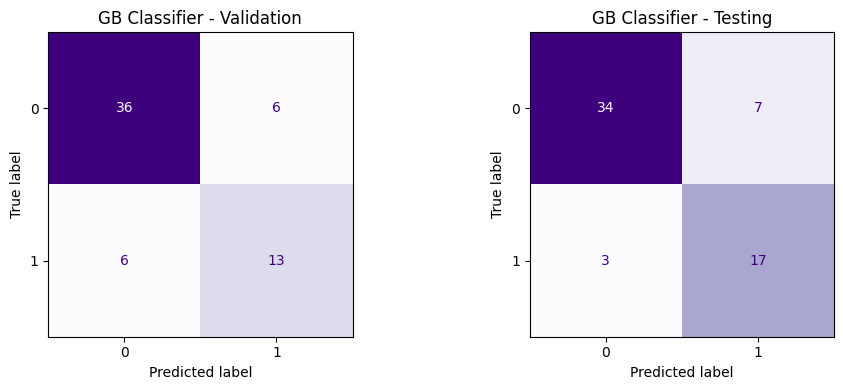

In [16]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('GB Classifier - Validation')

disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('GB Classifier - Testing')

plt.tight_layout()
plt.show()